In [242]:
import pandas as pd
import numpy as np
from string import punctuation
import re
from nltk.corpus import stopwords
from collections import Counter 
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from matplotlib import pyplot as plt
import random

In [243]:
torch.manual_seed(2023)
torch.cuda.manual_seed(2023)
random.seed(2023)

## 1. Exploratory Data Analysis and Data Cleaning

In [244]:
df = pd.read_csv('fb_sentiment.csv',index_col=0)

In [245]:
df.head()

,FBPost,Label
0,Drug Runners and a U.S. Senator have somethin...,O
1,"Heres a single, to add, to Kindle. Just read t...",O
2,If you tire of Non-Fiction.. Check out http://...,O
3,Ghost of Round Island is supposedly nonfiction.,O
4,Why is Barnes and Nobles version of the Kindle...,N


In [246]:
print("Dataset has {} posts.".format(df.shape[0]))

Dataset has 1000 posts.


It can be seen that the labels classes are imbalanced, it has to be taken into account while train/test split stage.

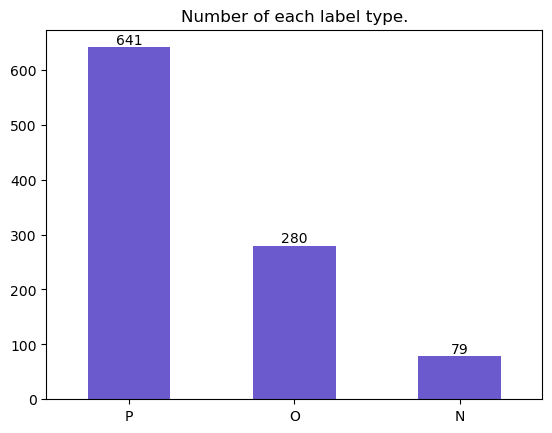

In [247]:
ax = df['Label'].value_counts().plot(kind='bar',color='slateblue',rot=0)
ax.bar_label(ax.containers[0])
plt.title("Number of each label type.")
plt.show()

In [248]:
# Extracting posts and labels from the dataframe.
posts, labels = df['FBPost'], df['Label']

# Encoding the labels.
labels=[2 if label.strip()=='P' else 1 if label.strip()=='O' else 0 for label in labels]

In [249]:
stop_words = stopwords.words('english')

def clean(post):
    """ Cleanes each post from unnecessary symbols."""
    
    post = post.lower()
    post = re.sub('http://\S+|https://\S+', '', post)
    post = re.sub('www.\S+', '', post)
    post = "".join([word for word in post if word not in punctuation])
    post = "".join([word for word in post if word.isalpha() or word==' '])
    post = re.sub(' +', ' ',post)
    post = post.split()
    post = " ".join([word for word in post if word not in stop_words])
    
    return post
    
corpus = [clean(post) for post in posts]

In [250]:
posts_lengths = [len(post.split()) for post in corpus]
print("Average length of the post: ", int(sum(posts_lengths)/len(posts_lengths)))

Average length of the post:  11


## 2. Feature extraction

In [251]:
def create_vocab(copus):
    text = " ".join(corpus)
    words = text.split()
    words_count = Counter(words)
    words_num=len(words)
    words_sorted=words_count.most_common(words_num)
    print("Most common words: ", words_sorted[:10],"\n")

    words_idx={w:i+1 for i,(w,c) in enumerate(words_sorted)}
    vocab_size = len(words_idx)
    print("The size of the vocabulary: ", vocab_size)
    
    return words_idx

words_idx = create_vocab(corpus)

Most common words:  [('kindle', 630), ('love', 378), ('books', 186), ('read', 157), ('one', 142), ('book', 125), ('reading', 104), ('would', 92), ('get', 78), ('like', 76)] 

The size of the vocabulary:  2839


In [252]:
def encode_post(post):
    """ Encode the post."""
    
    post_encoded=list()
    for word in post.split():
        if word not in words_idx.keys():
            post_encoded.append(0)
        else:
            post_encoded.append(words_idx[word])
            
    return post_encoded

corpus_encoded = [encode_post(post) for post in corpus]

In [253]:
def pad_post(corpus_encoded, sequence_length=30):
    """ Padding of the post."""
    
    features=np.zeros((len(corpus_encoded), sequence_length), dtype=int)
    for i, post in enumerate(corpus_encoded):
        post_len=len(post)
        if (post_len<=sequence_length):
            zeros=list(np.zeros(sequence_length-post_len))
            new=zeros+post
        else:
            new=post[:sequence_length]
        features[i,:]=np.array(new)
        
    return features

features = pad_post(corpus_encoded)

In [254]:
# Create train/validation/test datasets
X_train, X_val, y_train, y_val = train_test_split(features, labels, stratify=labels, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5)

train_data=TensorDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
valid_data=TensorDataset(torch.LongTensor(X_val), torch.LongTensor(y_val))
test_data=TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))

batch_size=20
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

## 3. RNN Model

The neural network is the combination of the standard RNN and LSTM.

In [260]:
class RnnSent(nn.Module):
    """The RNN model for Sentiment analysis."""
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        # Layers
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.fc1=nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, h):
        """Perform forward pass."""

        embed=self.embedding(x)
        lstm_out, (ht, ct) = self.lstm(embed, h)        
        out=self.fc1(ht[-1])

        return out, (ht, ct)
    
    def init_hidden(self, batch_size):
        """Initialize Hidden State"""
        
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [261]:
# Parameters for neural network
vocab_size = len(words_idx)+1
output_size = 3 # Corresponds to number of classes
embedding_dim = 400
hidden_dim = 25
n_layers = 2 # Number of LSTM units

net = RnnSent(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

RnnSent(
  (embedding): Embedding(2840, 400)
  (lstm): LSTM(400, 25, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=25, out_features=3, bias=True)
)


The next cell provides the training and validation loops.

Epoch: 1... Train mean cross-entropy loss: 0.995... Validation mean cross-entropy loss: 0.857
Epoch: 2... Train mean cross-entropy loss: 0.792... Validation mean cross-entropy loss: 0.784
Epoch: 3... Train mean cross-entropy loss: 0.668... Validation mean cross-entropy loss: 0.707
Epoch: 4... Train mean cross-entropy loss: 0.479... Validation mean cross-entropy loss: 0.653


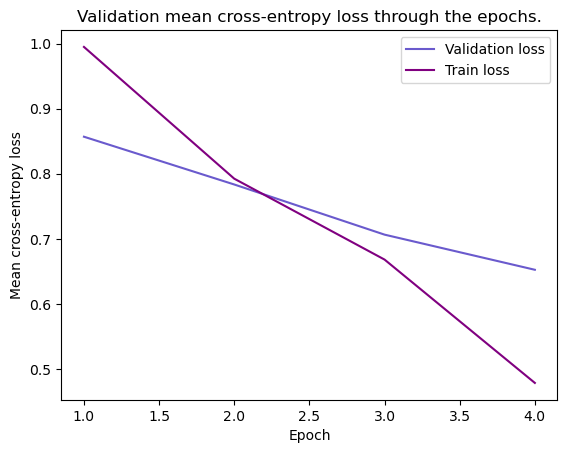

In [262]:
# Check availability of CUDA
train_on_gpu = torch.cuda.is_available()
device = torch.device("mps")
if(train_on_gpu):
    net.cuda()

# Training parameters
lr = 0.001
epochs = 4 # Larger number of epochs has been tested, but it leads to overfitting
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train the net
net.train()
val_losses_means, train_losses_means = [], []

for e in range(epochs):
    h = net.init_hidden(batch_size)
    train_losses = []
    
    # Loop through train batches
    for inputs, labels in train_loader:
        h = tuple([each.data for each in h])
        
        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()

        optimizer.zero_grad()
        
        output, h = net(inputs, h)
        loss = criterion(output.squeeze(), labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Validation
    net.eval()
    val_h = net.init_hidden(batch_size)
    val_losses = []
    
    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()  
            
        output, val_h = net(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels)
        val_losses.append(val_loss.item())
        
    val_losses_means.append(np.mean(val_losses))
    train_losses_means.append(np.mean(train_losses))

    print("Epoch: {}...".format(e+1),
          "Train mean cross-entropy loss: {:.3f}...".format(np.mean(train_losses)),
          "Validation mean cross-entropy loss: {:.3f}".format(np.mean(val_losses)))
    
    net.train()
    
plt.plot(np.array(range(epochs))+1, val_losses_means, color='slateblue', label = "Validation loss")
plt.plot(np.array(range(epochs))+1, train_losses_means, color='purple', label = "Train loss")
plt.title("Validation mean cross-entropy loss through the epochs.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean cross-entropy loss")
plt.show()

In [264]:
torch.save(net, "model_lstm.pt")

The next cell provides the test loop.

In [263]:
test_losses = []
test_correct_num = []

# init hidden state
h = net.init_hidden(batch_size)
net.eval()

for inputs, labels in test_loader:
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()


    output, h = net(inputs, h)
    test_loss = criterion(output.squeeze(), labels)
    test_losses.append(test_loss.item())

    softmax = nn.Softmax(dim=1)
    pred = softmax(output)
    pred = torch.argmax(pred, dim=1)
    correct_tensor = pred.eq(labels.view_as(pred)).numpy()
    test_correct_num.append(np.sum(correct_tensor))

test_accuracy_mean = sum(test_correct_num)/len(test_loader.dataset)
test_loss_mean = np.mean(test_losses)
print("Test mean cross-entropy loss: {:.3f}".format(np.mean(test_loss_mean)))
print("Test accuracy: {:.3f}".format(test_accuracy_mean))

Test mean cross-entropy loss: 0.645
Test accuracy: 0.810
